In [305]:
%pylab inline
from collections import Counter, defaultdict
import pandas as pd
import glob
import os
import itertools
from matplotlib.legend import Legend
from matplotlib.lines import Line2D

import seaborn as sns
sns.set_context('poster')#, font_scale=2)
sns.set_style('white')
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from ee546_utils import *
#MARKERS = list(Line2D.filled_markers)
MARKERS = ['o',  'x', '^', '*', 'H', '<', 's',  '>', '8', 'p', 'h',  'D', 'd', 'P']
TISSUES_SHORT_FORM_MAP = {'lv': 'liver',
                          'skm': 'muscle',
                          'br': 'brain',
                          'ht': 'heart',
                          'kd': 'kidney',
                          'cb': 'cerebellum',
                          'lv': 'liver',
                          'ts': 'testes'
                         }

SPECIES_COMMON_NAME_MAP = {"bos_taurus": "Cow",
                           "rattus_norvegicus": "Rat",
                           "pongo_abelii": "Orangutan",
                           "monodelphis_domestica": "Opossum",
                           "macaca_mulatta": "Macaque",
                           "pan_troglodytes": "Chimpanzee",
                           "mus_musculus": "Mouse",
                           "homo_sapiens": "Human",
                           "gallus_gallus": "Chicken",
                           "ornithorhynchus_anatinus":  "Platypus",
                           "gorilla_gorilla": "Gorilla",
                           "pan_paniscus": "Bonobo"}

SPECIES_COMMON_NAME_MAP_SHORT = {"btaurus": "Cow",
                                 "rnorvegicus": "Rat",
                                 "pabelii": "Orangutan",
                                 "mdomestica": "Opposum",
                                 "mmulatta": "Macaque",
                                 "ptroglodytes": "Chimpanzee",
                                 "mmusculus": "Mouse",
                                 "hsapiens": "Human",
                                 "ggallus": "Chicken",
                                 "oanatinus":  "Platypus",
                                 "ggorilla": "Gorrila",
                                 "ppaniscus": "Bonobos"}
def species_short(name):
    return name[0] + name.split('_')[1]


def _get_PCA_colors_markers(target_names):
    colors = {}
    indexes = defaultdict(list)
    all_species = {}
    row_colors = []
    for index, target_name in enumerate(target_names):
        species = target_name.split('_')[0]
        tissue = target_name.split('_')[2]
        if tissue not in colors.keys():
            colors[tissue] = sns.color_palette('tab10')[len(colors)]
        row_colors.append(colors[tissue])
        indexes[tissue].append(index)
        all_species[index] = species
        
    colors_dict = {}
    colors_list = []
    indexes_x = defaultdict(list)
    indexes_y = defaultdict(list)
    markers_dict = {}
    markers_list = []
    for index, target_name in enumerate(target_names):
        species = target_name.split('_')[0]
        tissue = target_name.split('_')[2]
        if tissue not in colors_dict.keys():
            colors_dict[tissue] = sns.color_palette('tab10')[len(colors_dict)]
        if species not in markers_dict.keys():
            markers_dict[species] = MARKERS[len(markers_dict)]
        markers_list.append(markers_dict[species])
        colors_list.append(colors_dict[tissue])
        indexes[tissue].append(index)
    return indexes, markers_list, colors_list, colors_dict, markers_dict

def do_PCA(X, target_names, ax=None):
    pca = PCA(n_components=min(X.shape))
    X_r = pca.fit(X).transform(X)
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 12))
    else:
        fig = ax.get_figure()
    colors = sns.color_palette('Paired')
    lw = 2
    indexes, markers_list, colors_list, colors_dict, markers_dict = _get_PCA_colors_markers(target_names)


    for tissue, values in indexes.items():
        for value in values:
            ax.scatter(X_r[value, 0], 
                       X_r[value, 1], 
                       color=colors_dict[tissue], 
                       marker=markers_list[value],
                       lw=5)
        
    scatter_points = []
    annotations = []
    for tissue, color in colors_dict.items():
        p = ax.scatter([], [], color=color, label=tissue)
        if tissue in TISSUES_SHORT_FORM_MAP.keys():
            tissue = TISSUES_SHORT_FORM_MAP[tissue]
        annotations.append(tissue)
        scatter_points.append(p)
        
   
    leg = Legend(ax, scatter_points, annotations, title='Tissue',
                 bbox_to_anchor=(0., 1.02, 1., .02), loc=0,
                 fancybox=True, shadow=True,borderaxespad=0,
                 ncol=5, mode="expand")
    ax.add_artist(leg)

    scatter_points = []
    annotations = []
    for species, marker in markers_dict.items():
        p = ax.scatter([], [], marker=marker, color='black', label=species)
        annotations.append(SPECIES_COMMON_NAME_MAP_SHORT[species])
        scatter_points.append(p)
        
    #leg = Legend(ax, scatter_points, annotations, title='Species',
    #             bbox_to_anchor=(1.04, 0), loc="lower left",)# frameon=False)
    leg = Legend(ax, scatter_points, annotations, title='Species',
                 bbox_to_anchor=(1, 1), loc='upper right',borderaxespad=0,
                 #bbox_to_anchor=(0.5, -0.05), loc=0, ncol=5,
                 )# frameon=False)
    ax.add_artist(leg)
    
    #ax.set_title('PCA')
    ax.set_xlabel('PC1 ({:.2f} %)'.format(pca.explained_variance_ratio_[0]*100))
    ax.set_ylabel('PC2 ({:.2f} %)'.format(pca.explained_variance_ratio_[1]*100))
    #fig.tight_layout()
    
    return X_r, fig

def _get_CCA_colors_markers(target_names):
    colors_dict = {}
    colors_list = []
    indexes_x = defaultdict(list)
    indexes_y = defaultdict(list)
    markers_dict = {}
    markers_list = []
    for index, target_name in enumerate(target_names):
        species = target_name.split('_')[0]
        tissue = target_name.split('_')[2]
        if tissue not in colors_dict.keys():
            colors_dict[tissue] = sns.color_palette('tab10')[len(colors_dict)]
        if species not in markers_dict.keys():
            markers_dict[species] = MARKERS[len(markers_dict)]
        markers_list.append(markers_dict[species])
        colors_list.append(colors_dict[tissue])
        if index < X.shape[0]:
            indexes_x[tissue].append(index)
        else:
            indexes_y[tissue].append(index-X.shape[0])
    return indexes_x, indexes_y, markers_list, colors_list, colors_dict, markers_dict
    
def do_CCA(X, Y, target_names, ax=None):
    
    
    cca = CCA(n_components=2)
    cca.fit(X, Y)
    X_c, Y_c = cca.transform(X, Y)
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8.5))
    else:
        fig = ax.get_figure()    #assert 
    indexes_x, indexes_y, markers_list, colors_list, colors_dict, markers_dict = _get_CCA_colors_markers(target_names)
    for tissue, values in indexes_x.items():
        for value in values:
            ax.scatter(X_c[value, 0], 
                       X_c[value, 1], 
                       color=colors_dict[tissue], 
                       marker=markers_list[value],
                       lw=5)
    for tissue, values in indexes_y.items():
        for value in values:
            ax.scatter(Y_c[value, 0], 
                       Y_c[value, 1], 
                       color=colors_dict[tissue], 
                       marker=markers_list[value+X_c.shape[0]],
                       lw=5)
    scatter_points = []
    annotations = []
    for tissue, color in colors_dict.items():
        p = ax.scatter([], [], color=color, label=tissue)
        if tissue in TISSUES_SHORT_FORM_MAP.keys():
            tissue = TISSUES_SHORT_FORM_MAP[tissue]
        annotations.append(tissue)
        scatter_points.append(p)
        
    #leg = Legend(ax, scatter_points, annotations, title='Tissue',
    #             bbox_to_anchor=(1.04,1), loc="upper left",)
    
    leg = Legend(ax, scatter_points, annotations, title='Tissue',
                 bbox_to_anchor=(0., 1.02, 1., .02), loc=0,
                 fancybox=True, shadow=True,borderaxespad=0,
                 ncol=5, mode="expand")
    ax.add_artist(leg)

    scatter_points = []
    annotations = []
    for species, marker in markers_dict.items():
        p = ax.scatter([], [], marker=marker, color='black', label=species)
        annotations.append(SPECIES_COMMON_NAME_MAP_SHORT[species])
        scatter_points.append(p)
        
    #leg = Legend(ax, scatter_points, annotations, title='Species',
    #             bbox_to_anchor=(1.04, 0), loc="lower left",)# frameon=False)
    leg = Legend(ax, scatter_points, annotations, title='Species',
                 bbox_to_anchor=(1, 1), loc='upper right',borderaxespad=0)
    ax.add_artist(leg)
    #ax.set_title('CCA')
    ax.set_xlabel('CC1')
    ax.set_ylabel('CC2')
    #fig.tight_layout()
    #fig.tight_layout()
    return fig

Populating the interactive namespace from numpy and matplotlib


/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/scanpy/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


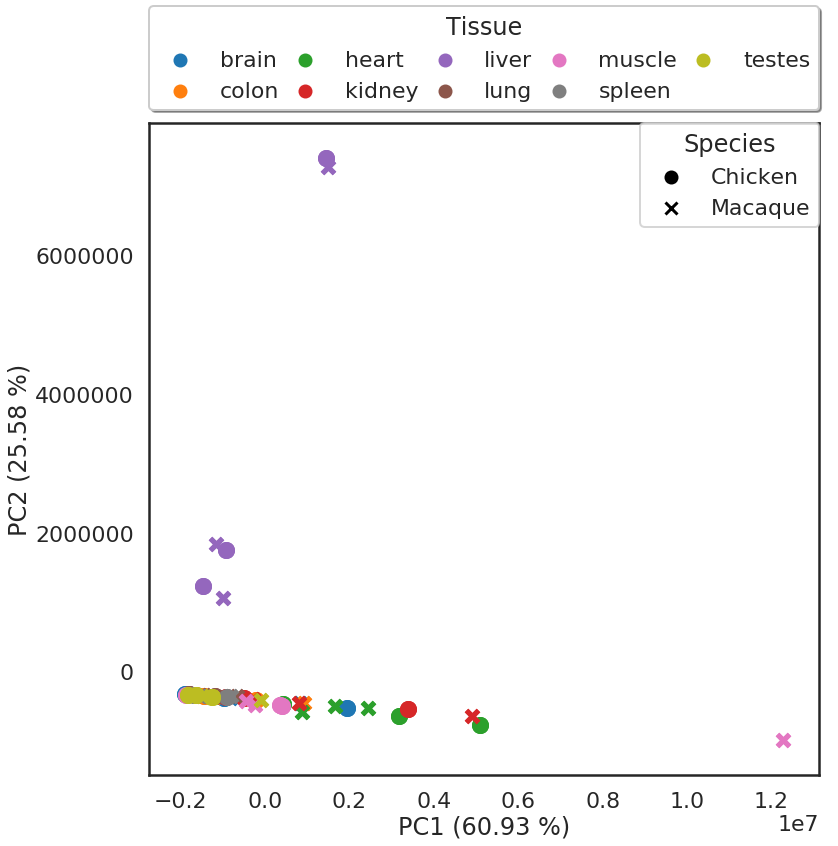

In [287]:
X = pairwise_kallisto_counts['ggallus_mmulatta'].values
target_names = pairwise_kallisto_counts['ggallus_mmulatta'].index
X_r, fig = do_PCA(X, target_names)

# 01. Read Data

In [5]:
ortho_pairwise = {}
for f in glob.glob('../ortholog_tsv/*.tsv'):
    if 'ortholog_one2one' in f:
        continue
    second_species = f.split('/')[-1].replace('.tsv', '').split('_')[-1]
    print(f)
    ortho_pairwise[f.split('/')[-1].replace('.tsv', '')] = pd.read_table(f)[['ensembl_gene_id', '{}_homolog_ensembl_gene'.format(second_species), '{}_homolog_orthology_type'.format(second_species)]].set_index('ensembl_gene_id')

../ortholog_tsv/mmusculus_btaurus.tsv
../ortholog_tsv/mmusculus_ggallus.tsv
../ortholog_tsv/mmusculus_ggorilla.tsv
../ortholog_tsv/mmusculus_hsapiens.tsv
../ortholog_tsv/mmusculus_mdomestica.tsv
../ortholog_tsv/mmusculus_mmulatta.tsv
../ortholog_tsv/mmusculus_oanatinus.tsv
../ortholog_tsv/mmusculus_pabelii.tsv
../ortholog_tsv/mmusculus_ppaniscus.tsv
../ortholog_tsv/mmusculus_ptroglodytes.tsv
../ortholog_tsv/mmusculus_rnorvegicus.tsv


In [129]:
MARKERS

['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']

In [6]:
ONE2ONE_orthologs = pd.read_table('../ortholog_tsv/ortholog_one2one.tsv')

In [ ]:
'../cross-species-data/SRP016501_sample_info.tsv

# 02. Read kallisto tables SRP007412

In [30]:
kallisto_counts = {}
srp_species =  defaultdict(list)
for f in glob.glob('../cross-species-data/SRP007412-*_kallisto_gene_tables.tsv'):
    sample_name = f.split('/')[-1].replace('_kallisto_gene_tables.tsv', '')
    srp, species = sample_name.split('-')
    species = species[0] + species.split('_')[-1]
    kallisto_counts['{}_{}'.format(srp, species)] = pd.read_table(f)
    srp_species[srp].append(species)

# 03. Read kallisto tables SRP016501

In [31]:
for f in glob.glob('../cross-species-data/SRP016501-*_kallisto_gene_tables.tsv'):
    sample_name = f.split('/')[-1].replace('_kallisto_gene_tables.tsv', '')
    srp, species = sample_name.split('-')
    species = species[0] + species.split('_')[-1]
    kallisto_counts['{}_{}'.format(srp, species)] = pd.read_table(f)
    srp_species[srp].append(species)               

In [96]:
srp = 'SRP016501'
pairwise_kallisto_counts = {}
pairwise_kallisto_counts_normalized = {}
pairwise_kallisto_counts_normalized_individual = defaultdict(dict)
for species1, species2 in itertools.combinations(srp_species[srp], 2):
    # load counts
    counts1 = kallisto_counts['{}_{}'.format(srp, species1)]
    counts2 = kallisto_counts['{}_{}'.format(srp, species2)]
    
    if species1 ==  'mmusculus':
        species1, species2 = species2, species1
        counts1, counts2 = counts2, counts1
        #cols_to_use = counts1.columns.tolist()
        # Only use these columns in the second dataframe
        #counts2 = counts2.loc[:, cols_to_use]
    if species2 ==  'mmusculus':
        cols_to_use = counts2.columns.tolist()
        # Only use these columns in the second dataframe
        counts1 = counts1.loc[:, cols_to_use]
    print(species1, species2)
    if species2 != 'mmusculus':
        ortho1 = ortho_pairwise['mmusculus_{}'.format(species1)]
        ortho1 = ortho1.loc[ortho1['{}_homolog_orthology_type'.format(species1)]=='ortholog_one2one']
        ortho1 = ortho1.drop(columns=['{}_homolog_orthology_type'.format(species1)]) 
    
        ortho2 = ortho_pairwise['mmusculus_{}'.format(species2)]
        ortho2 = ortho2.loc[ortho2['{}_homolog_orthology_type'.format(species2)]=='ortholog_one2one']
        ortho2 = ortho2.drop(columns=['{}_homolog_orthology_type'.format(species2)]) 
        
        ortho_12 = ortho1.join(ortho2, how='outer').dropna().reset_index(drop=True)\
                    .set_index('{}_homolog_ensembl_gene'.format(species1))
        species2_lookup_col = '{}_homolog_ensembl_gene'.format(species2)
        species1_ortho_genes  = ortho_12.index
        species2_ortho_genes  = ortho_12['{}_homolog_ensembl_gene'.format(species2)]
        
        
        counts1_trimmed = counts1.loc[species1_ortho_genes].dropna()
        counts2_trimmed = counts2.loc[species2_ortho_genes].dropna()
    
        new_index_genes = counts1_trimmed.index
        reduced_set = ortho_12.loc[new_index_genes]
        reduced_set = reduced_set.loc[reduced_set[species2_lookup_col].isin(counts2_trimmed.index)]
        counts1_trimmed = counts1_trimmed.loc[reduced_set.index]
        counts2_trimmed = counts2_trimmed.loc[reduced_set[species2_lookup_col]]
        del ortho_12
        del reduced_set
        del ortho1
        del ortho2
    else:
        
        ortho = ortho_pairwise['mmusculus_{}'.format(species1)]
        ortho = ortho.loc[ortho['{}_homolog_orthology_type'.format(species1)]=='ortholog_one2one']
        ortho = ortho.drop(columns=['{}_homolog_orthology_type'.format(species1)]) 
        species2_lookup_col = '{}_homolog_ensembl_gene'.format(species1)

        species1_ortho_genes  = ortho['{}_homolog_ensembl_gene'.format(species1)]
        species2_ortho_genes  = ortho.index.tolist()
        
        counts1_trimmed = counts1.loc[species1_ortho_genes].dropna()
        counts2_trimmed = counts2.loc[species2_ortho_genes].dropna()
    
        new_index_genes = counts2_trimmed.index
        reduced_set = ortho.loc[new_index_genes]
        reduced_set = reduced_set.loc[reduced_set[species2_lookup_col].isin(counts1_trimmed.index)]
        counts1_trimmed = counts1_trimmed.loc[reduced_set[species2_lookup_col]]
        counts2_trimmed = counts2_trimmed.loc[reduced_set.index]                        
        del ortho
    if len(counts1.columns)!= len(counts2.columns):
        print('Skipping {}, {}'.format(species1, species2))
        continue
    assert (counts1.columns == counts2.columns).all()
    
    counts1_trimmed.columns =  ['{}_{}'.format(species1, x) for x in counts1_trimmed.columns]
    counts2_trimmed.columns =  ['{}_{}'.format(species2, x) for x in counts2_trimmed.columns]
    
    del counts1
    del counts2
    counts2_trimmed.index = counts1_trimmed.index.tolist()
    counts_concat = pd.concat([counts1_trimmed.T, counts2_trimmed.T], ignore_index=False)
    pairwise_kallisto_counts['{}_{}'.format(species1, species2)] = counts_concat
    
    counts_concat_centered = counts_concat.sub(counts_concat.mean(axis=1), axis=0)
    counts_concat_centered = counts_concat_centered.div(counts_concat_centered.std(axis=1), axis=0)
    
    pairwise_kallisto_counts_normalized['{}_{}'.format(species1, species2)] = counts_concat_centered
    pairwise_kallisto_counts_normalized_individual['{}_{}'.format(species1, species2)][species1] = counts_concat_centered.iloc[:len(counts1_trimmed.T.index),]
    pairwise_kallisto_counts_normalized_individual['{}_{}'.format(species1, species2)][species2] = counts_concat_centered.iloc[len(counts1_trimmed.T.index):,]

ggallus mmulatta
ggallus btaurus
ggallus mmusculus


/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/scanpy/lib/python3.6/site-packages/ipykernel/__main__.py:37: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/scanpy/lib/python3.6/site-packages/ipykernel/__main__.py:38: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/scanpy/lib/python3.6/site-packages/ipykernel/__main__.py:59: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the fu

ggallus rnorvegicus
mmulatta btaurus
mmulatta mmusculus
mmulatta rnorvegicus
btaurus mmusculus
btaurus rnorvegicus
rnorvegicus mmusculus


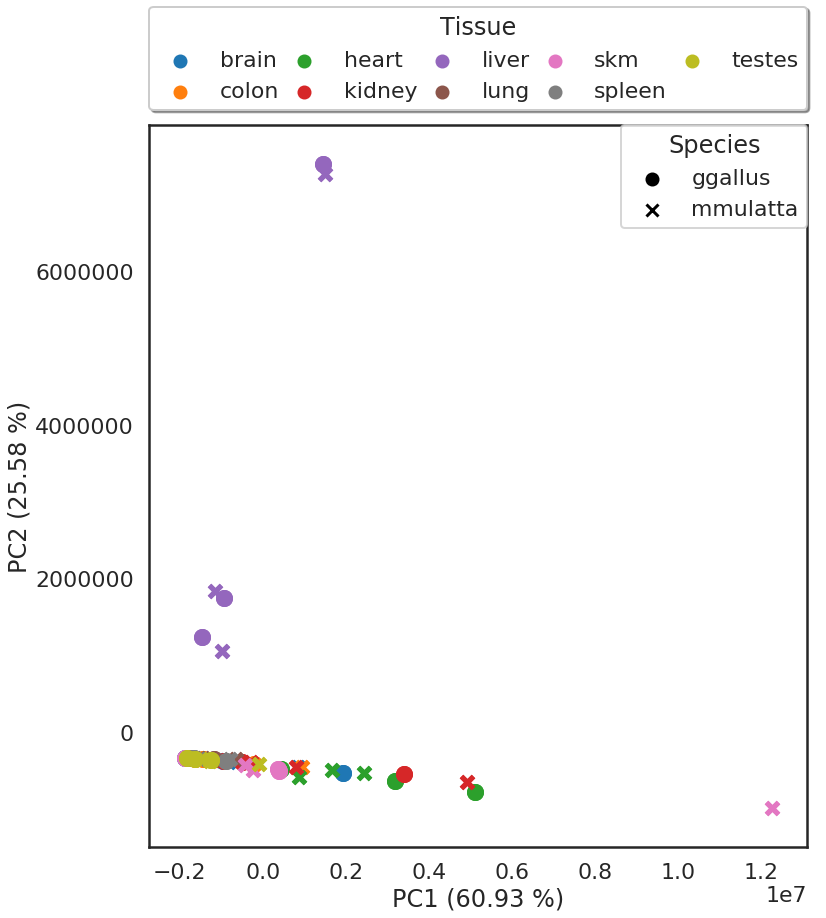

In [267]:
X = pairwise_kallisto_counts['ggallus_mmulatta'].values
target_names = pairwise_kallisto_counts['ggallus_mmulatta'].index
X_r, fig = do_PCA(X, target_names)

explained variance ratio (first two components): [2.90077072e-01 1.76567163e-01 1.04805534e-01 8.56671841e-02
 7.51156118e-02 6.25027818e-02 3.84854914e-02 2.89381864e-02
 2.37866017e-02 1.34651320e-02 1.21193161e-02 1.11703653e-02
 9.49058669e-03 8.50506668e-03 8.09064943e-03 6.48475819e-03
 5.05768049e-03 4.90674062e-03 4.30606773e-03 3.69354218e-03
 3.42373777e-03 3.12842529e-03 2.93293839e-03 2.48490486e-03
 2.04156933e-03 1.70011308e-03 1.46995856e-03 1.20183111e-03
 1.03669711e-03 9.16893115e-04 8.64751719e-04 7.04536209e-04
 6.41090633e-04 5.89572756e-04 5.29704019e-04 3.89373521e-04
 3.67457313e-04 2.99240891e-04 2.78288357e-04 2.62533649e-04
 2.36543673e-04 2.04662563e-04 1.62349296e-04 1.54922633e-04
 1.24990044e-04 1.20604356e-04 1.07752782e-04 1.04287784e-04
 8.01307004e-05 7.42342091e-05 6.86635221e-05 4.86525515e-05
 1.30560937e-05 5.72076154e-32]


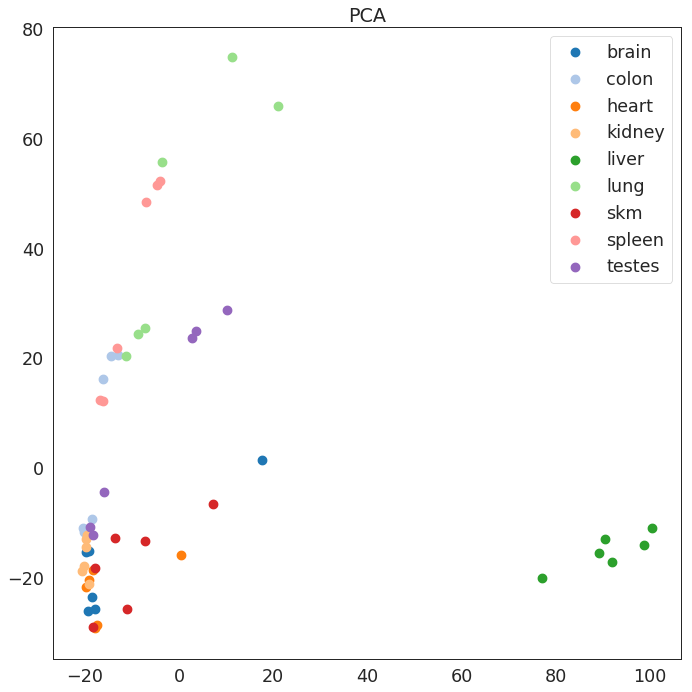

In [112]:
X = pairwise_kallisto_counts_normalized['ggallus_mmulatta'].values
target_names = pairwise_kallisto_counts_normalized['ggallus_mmulatta'].index
X_r = do_PCA(X, target_names)

In [114]:
X_r.shape

(54, 54)

In [115]:
X.shape[0]

54

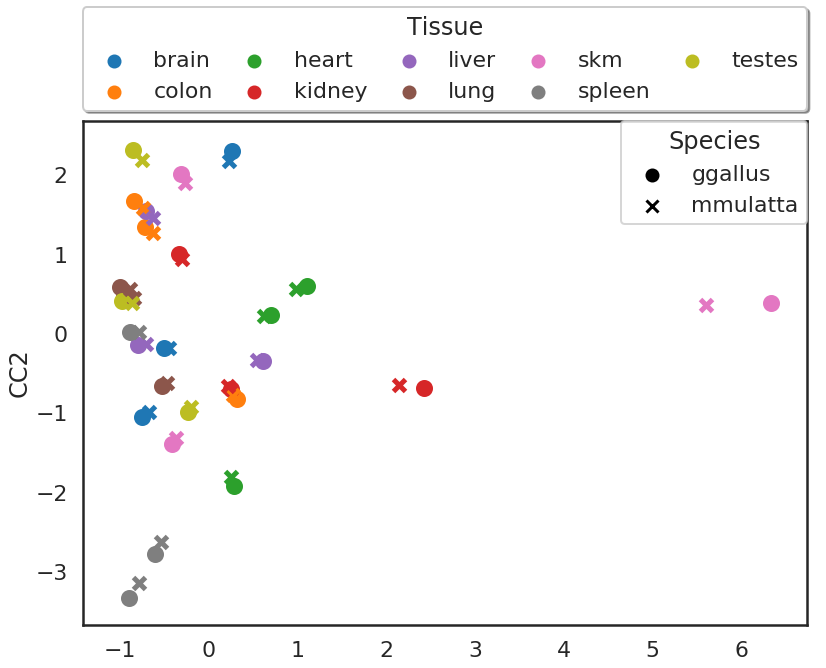

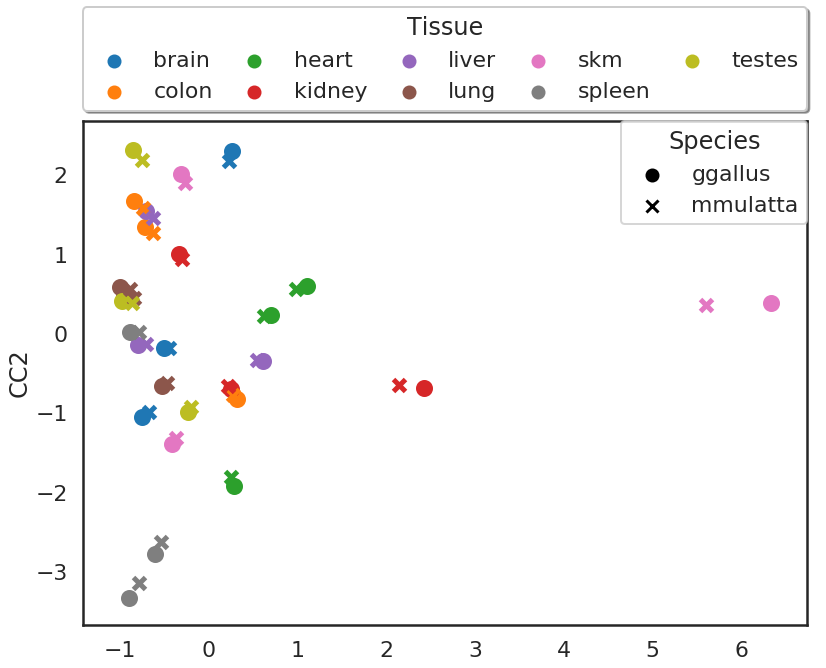

In [271]:
X = pairwise_kallisto_counts_normalized_individual['ggallus_mmulatta']['ggallus']

X = X_r[:X.shape[0],]
Y = X_r[X.shape[0]:,]
fig = do_CCA(X, Y, target_names)
fig.s

explained variance ratio (first two components): [6.09333905e-01 2.55830319e-01 4.64313760e-02 3.34275069e-02
 1.22705213e-02 9.00886635e-03 6.62654090e-03 4.25815139e-03
 3.16666973e-03 3.09783491e-03 2.69975400e-03 1.86811984e-03
 1.66895853e-03 1.50002108e-03 1.43541902e-03 1.35962214e-03
 1.07955133e-03 9.46849618e-04 7.50115489e-04 7.04774370e-04
 5.56462007e-04 5.23796229e-04 3.46045611e-04 1.63258326e-04
 1.53112837e-04 1.35551352e-04 1.14566416e-04 9.69506006e-05
 6.68139774e-05 5.87254130e-05 4.25917299e-05 3.91467146e-05
 3.33627050e-05 3.03101388e-05 2.76348937e-05 2.23609557e-05
 1.84703961e-05 1.59213434e-05 1.43167630e-05 1.30905451e-05
 1.18062655e-05 9.39215278e-06 8.84825904e-06 7.23898840e-06
 5.06426301e-06 4.30181372e-06 3.53749878e-06 3.35982168e-06
 2.70705145e-06 2.37572144e-06 1.98817929e-06 1.91638508e-06
 9.83743917e-08 1.12041638e-32]


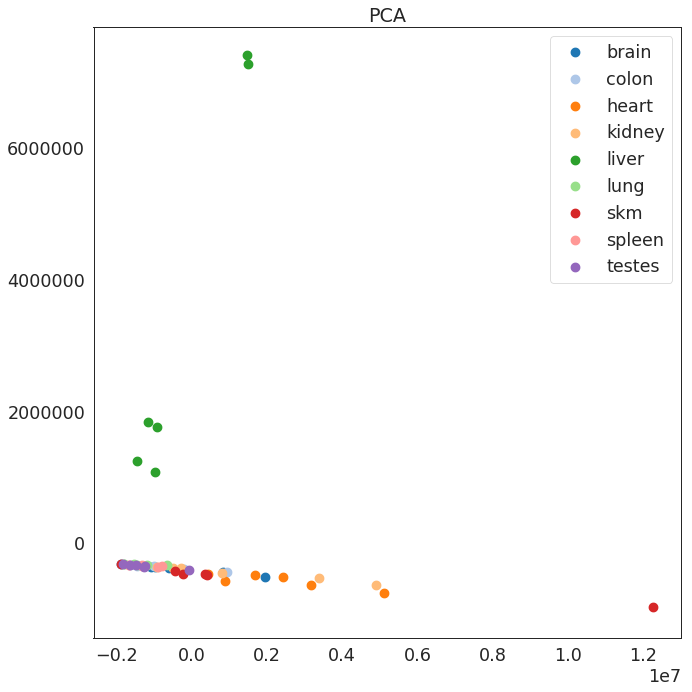

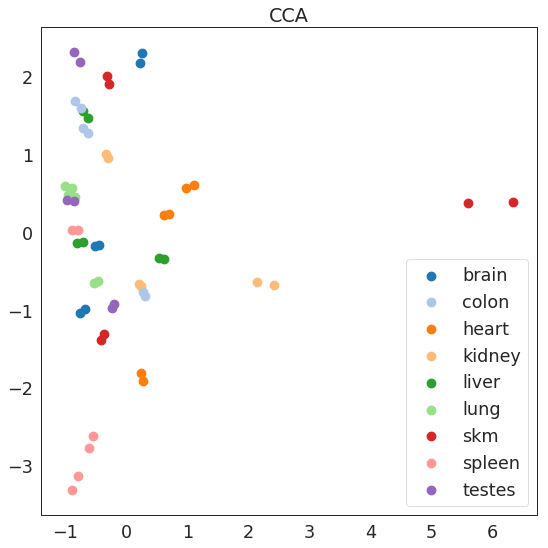

In [117]:
X = pairwise_kallisto_counts['ggallus_mmulatta'].values
target_names = pairwise_kallisto_counts['ggallus_mmulatta'].index
X_r = do_PCA(X, target_names) 

X = pairwise_kallisto_counts_normalized_individual['ggallus_mmulatta']['ggallus']

X = X_r[:X.shape[0],]
Y = X_r[X.shape[0]:,]
do_CCA(X, Y, target_names)


/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/scanpy/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/scanpy/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/scanpy/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 2

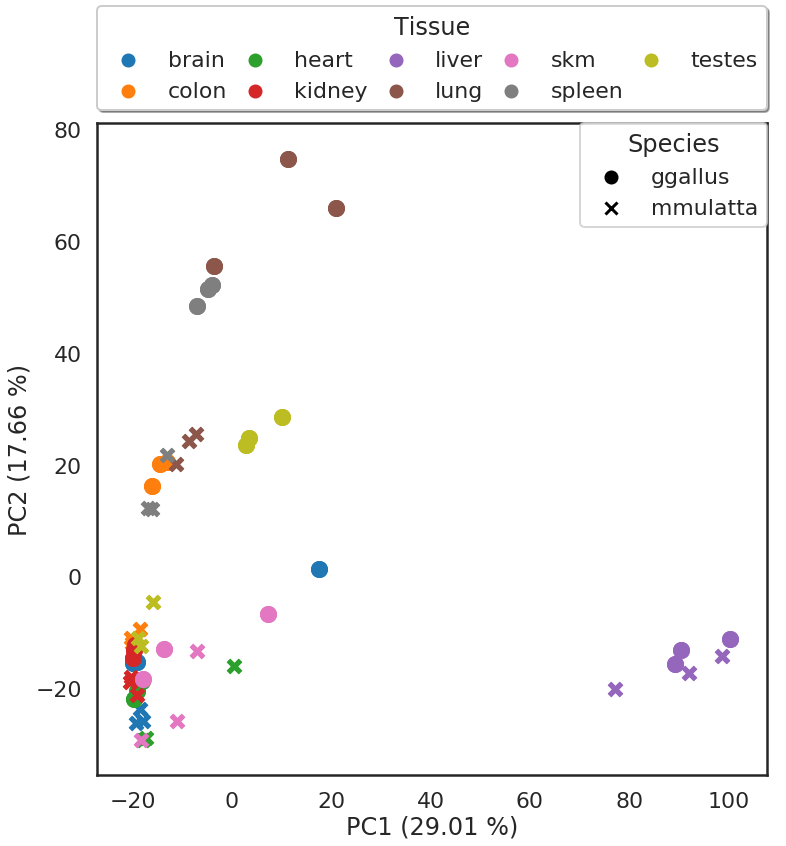

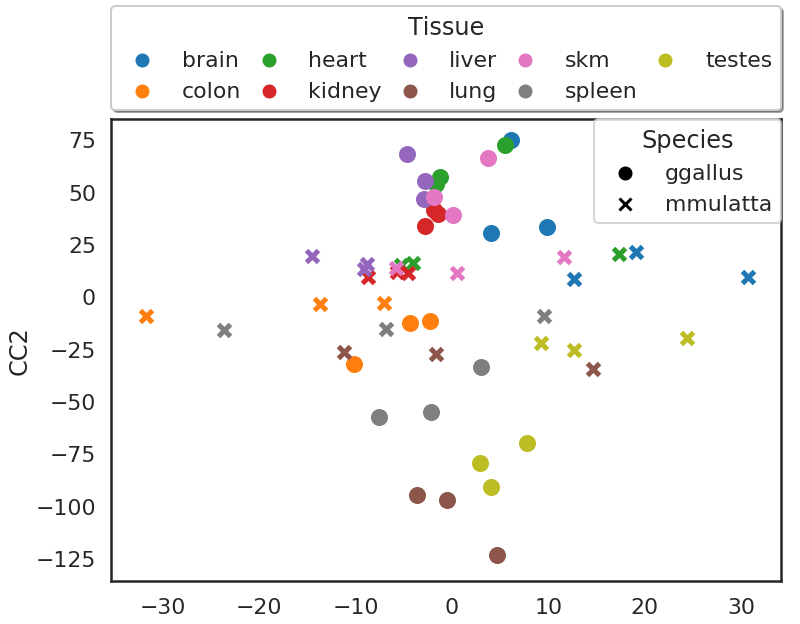

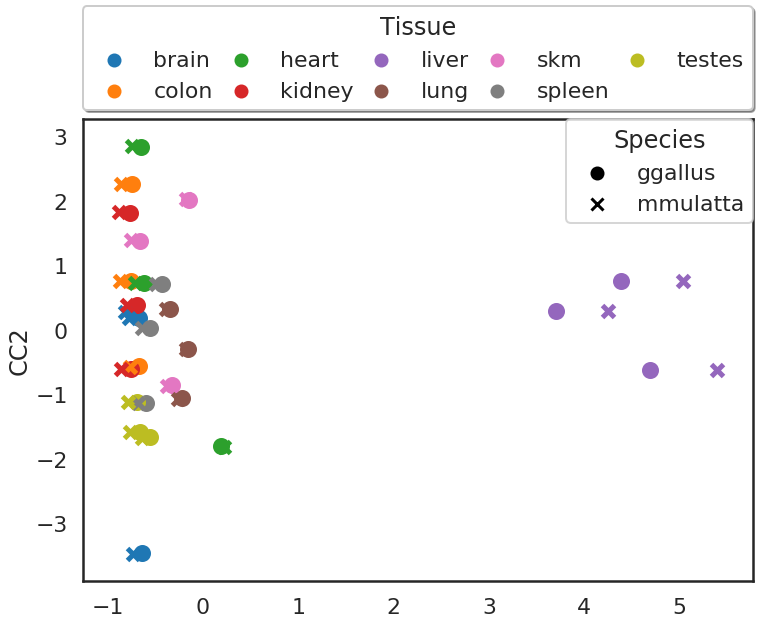

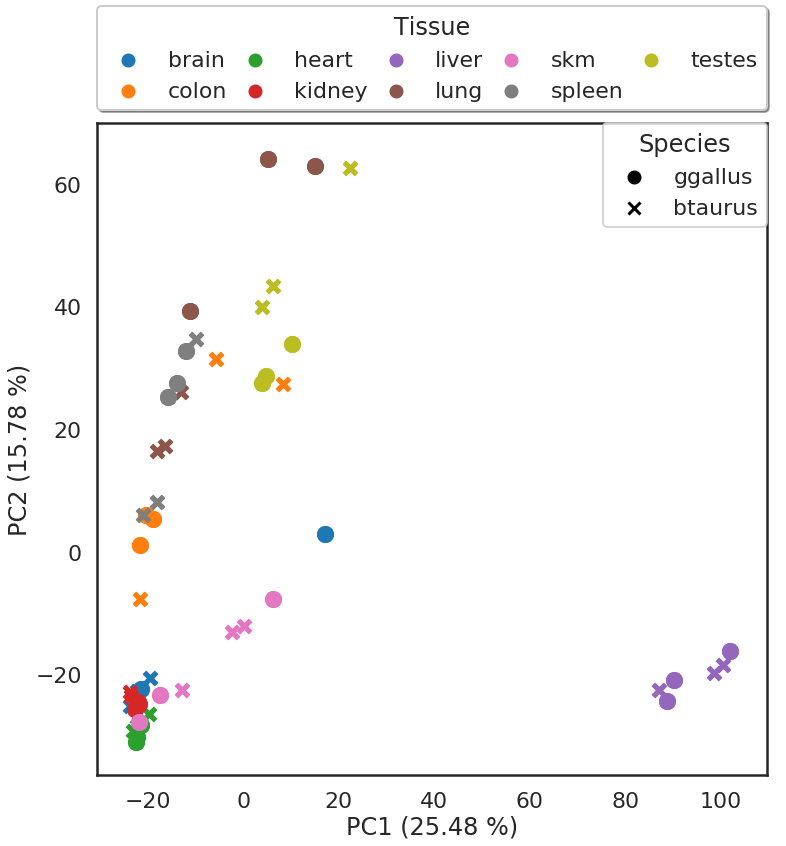

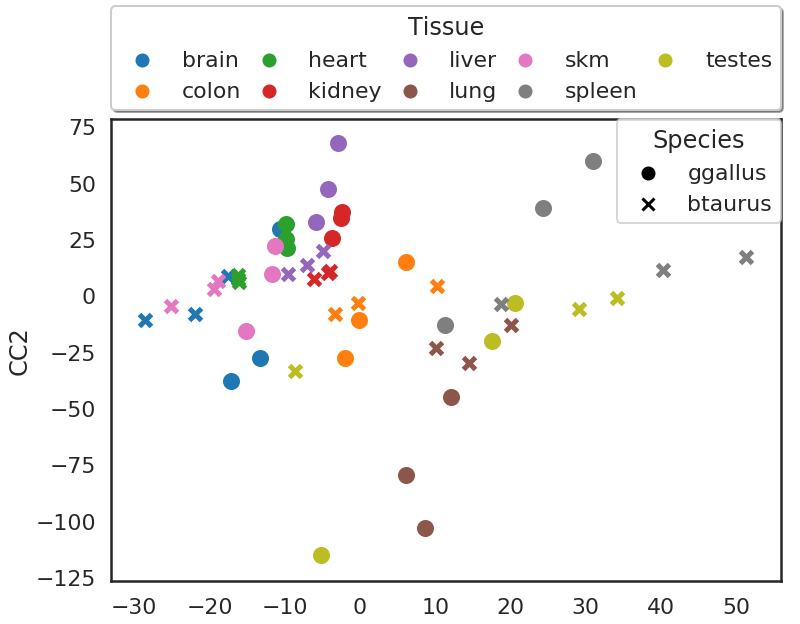

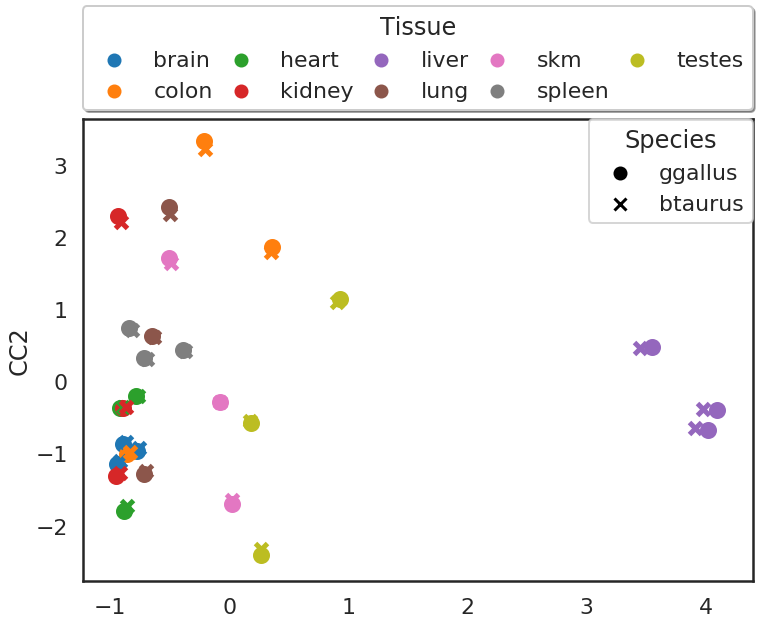

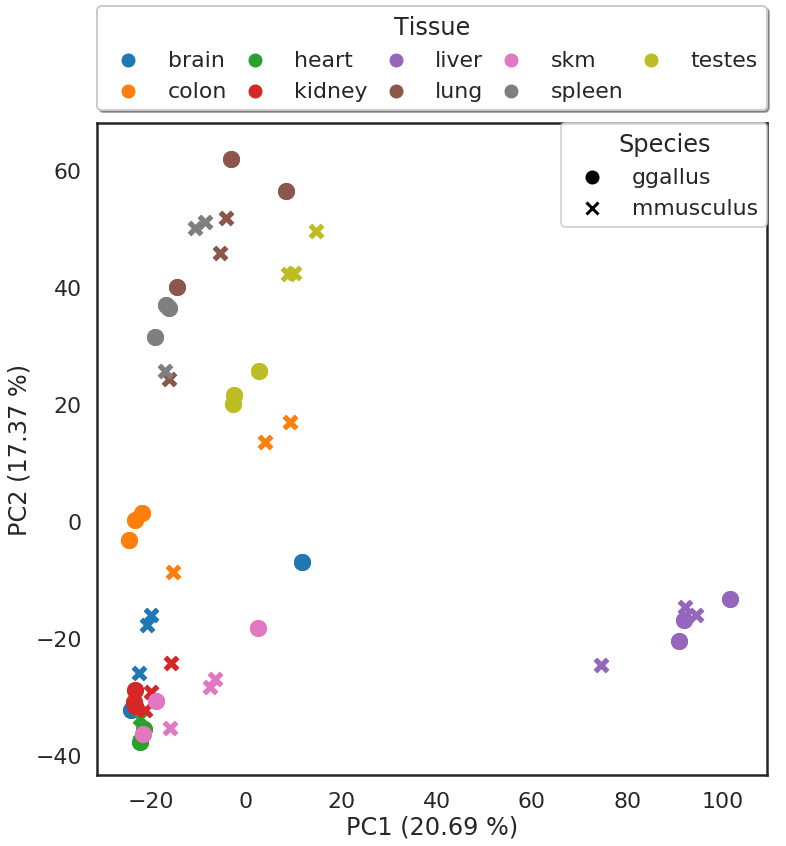

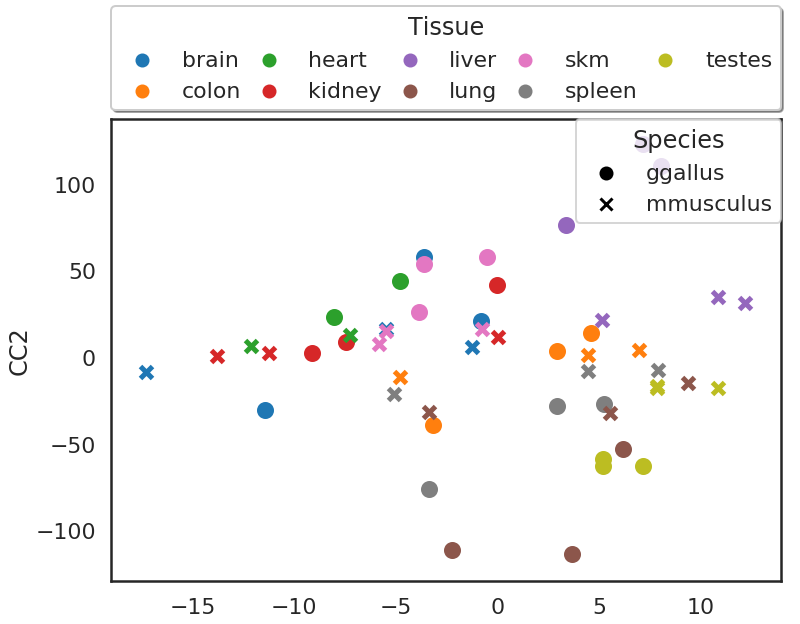

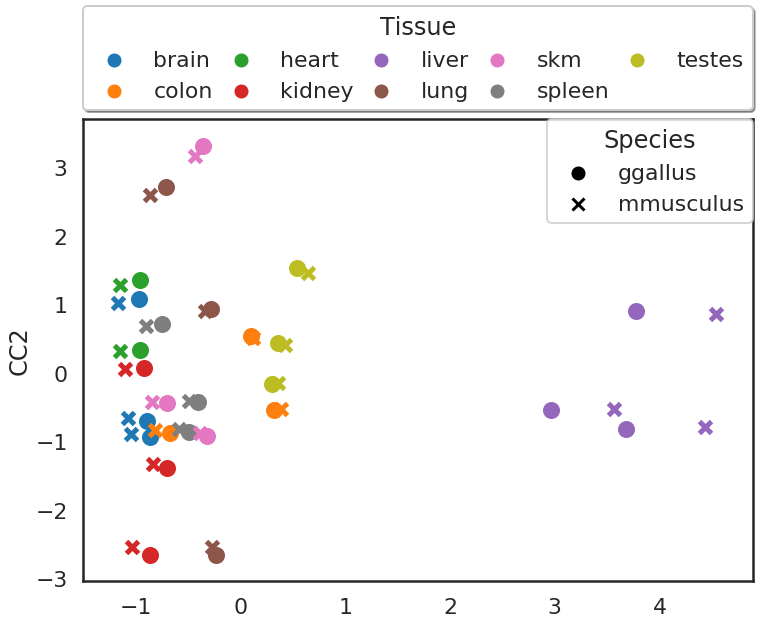

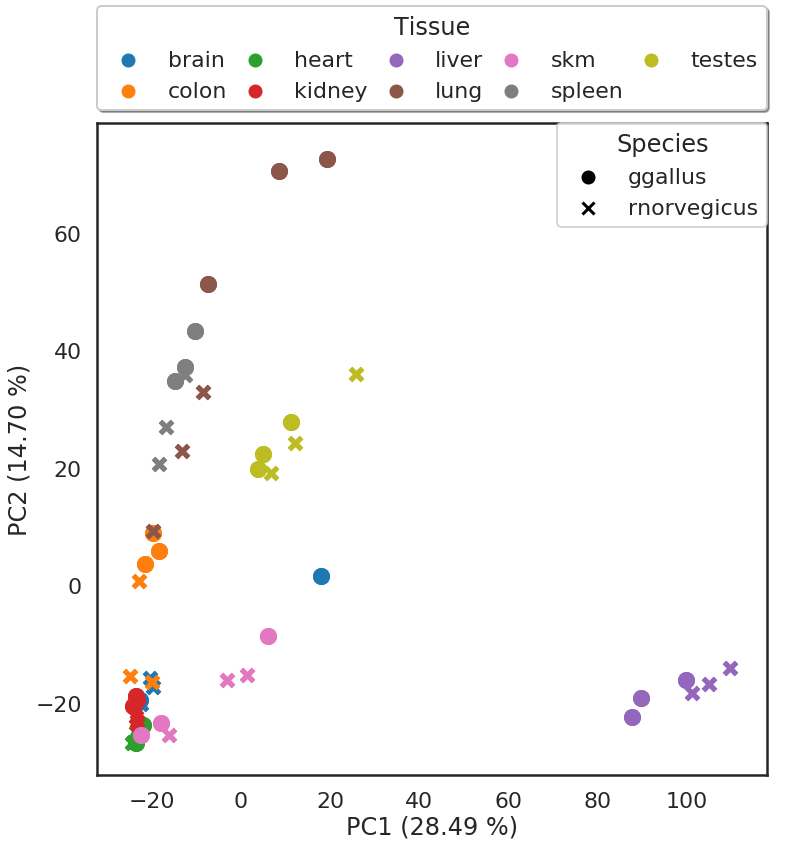

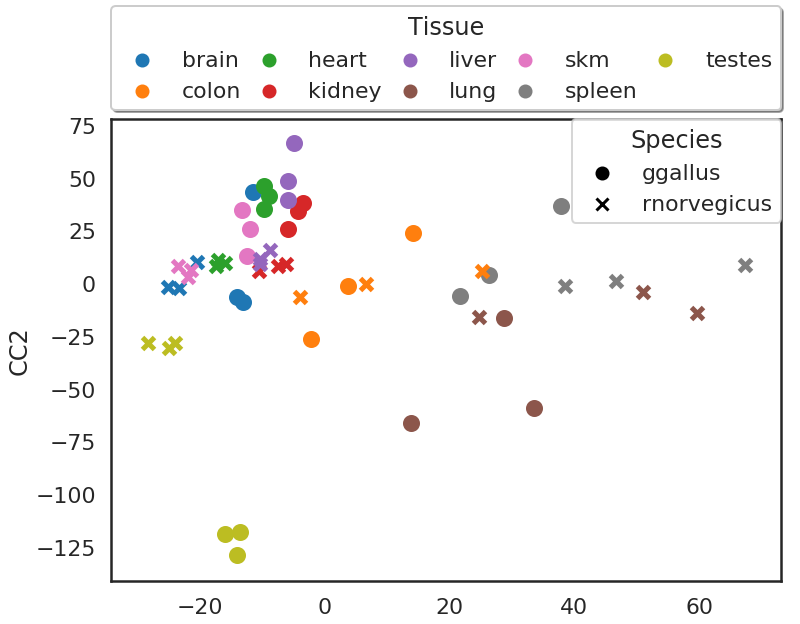

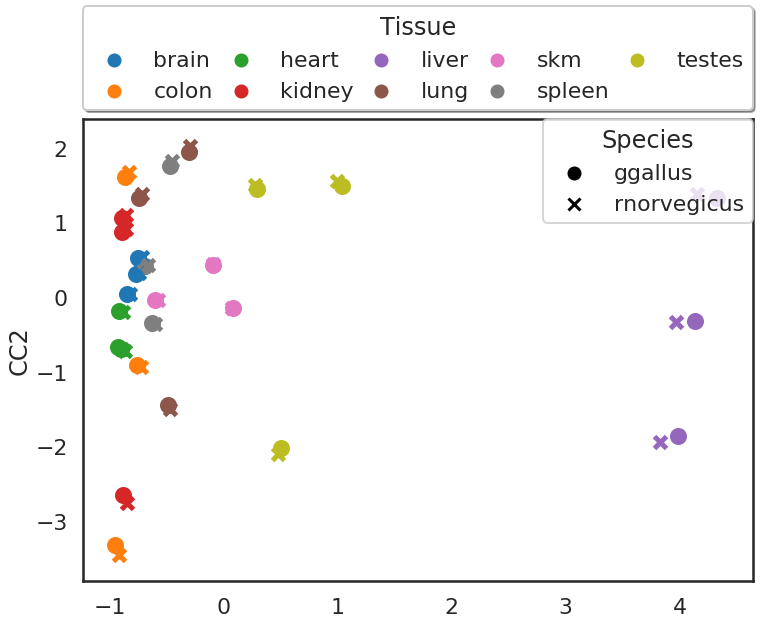

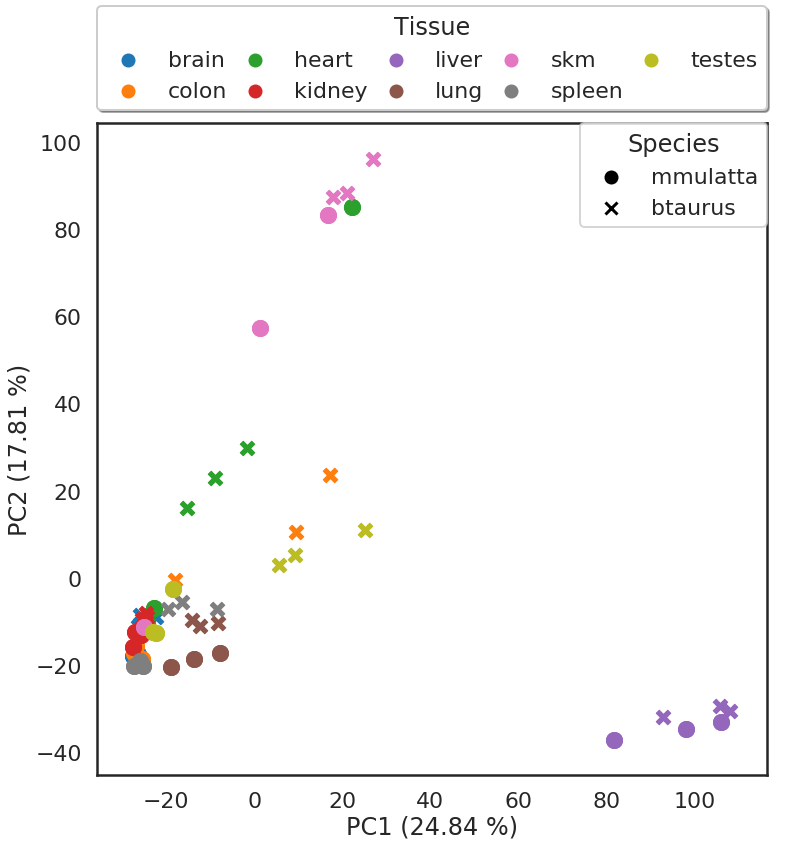

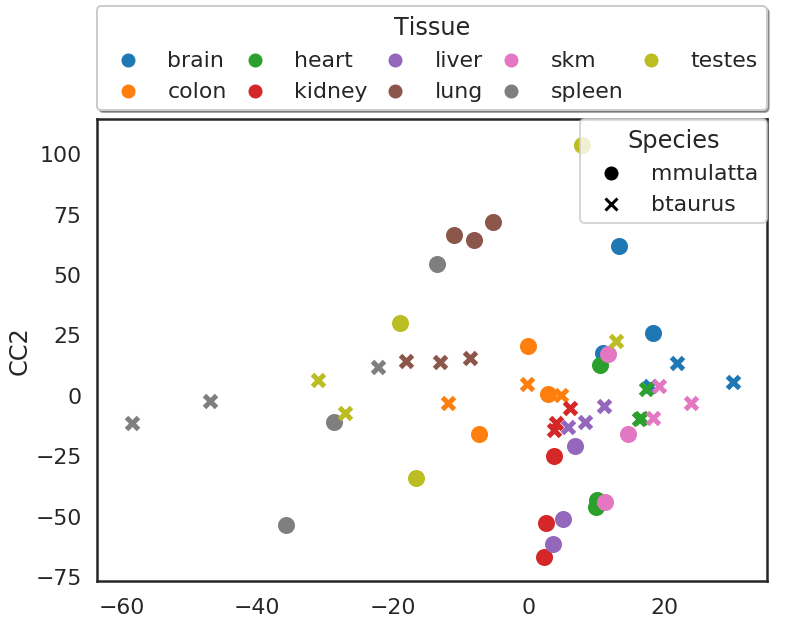

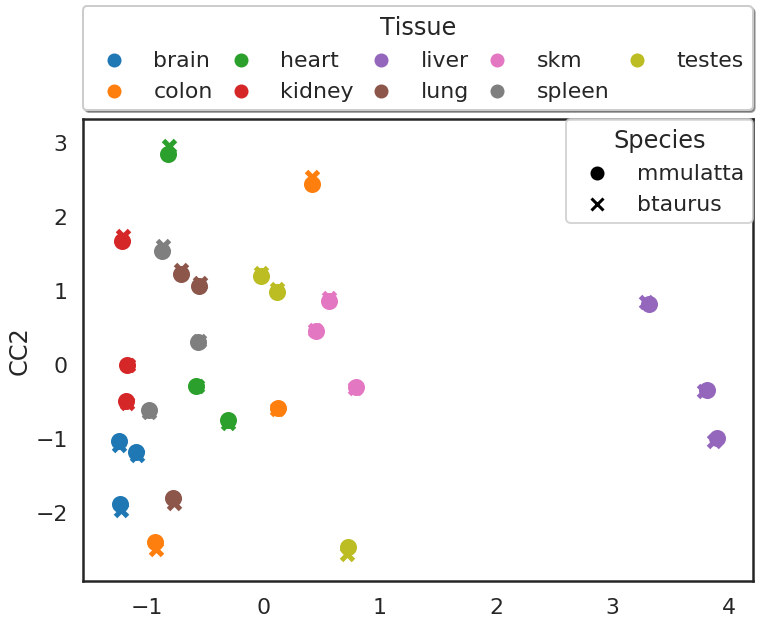

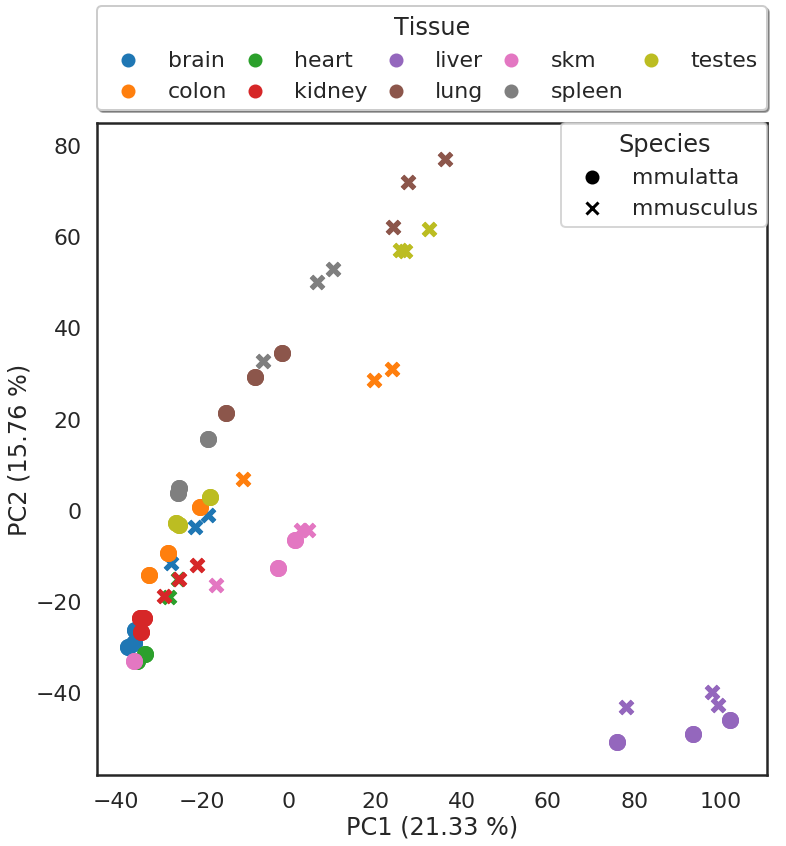

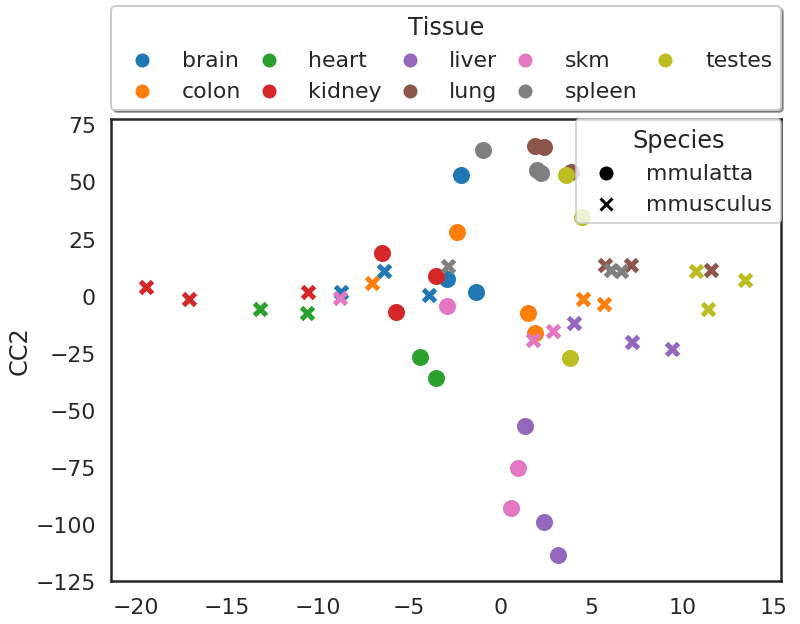

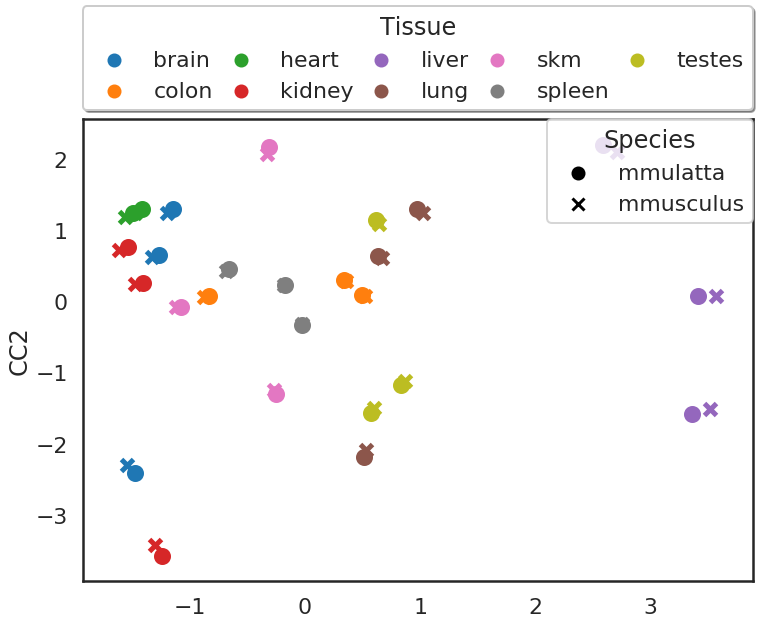

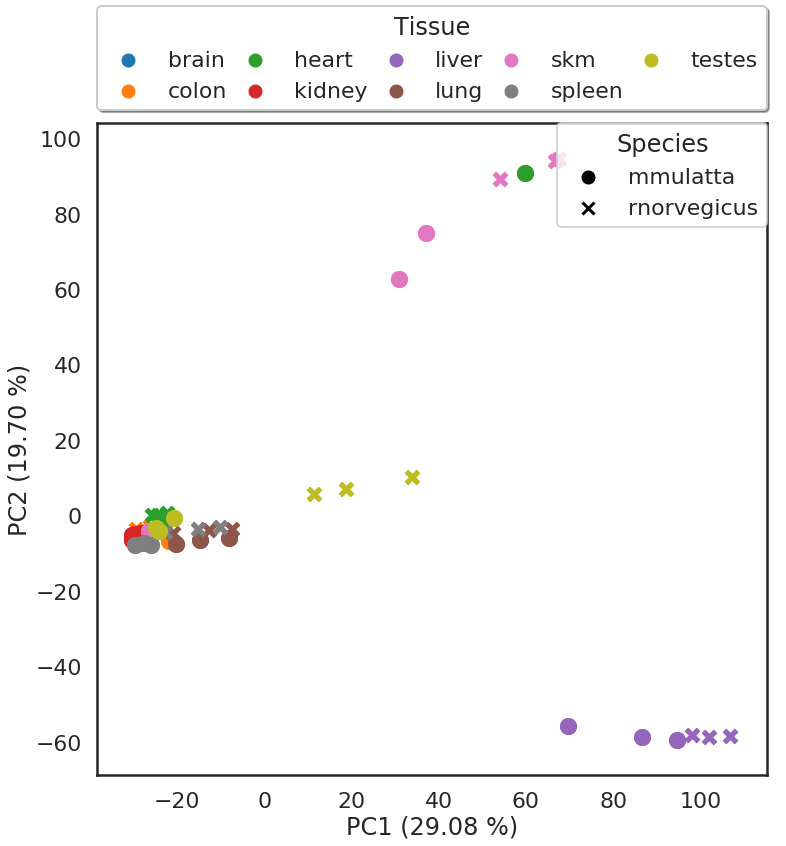

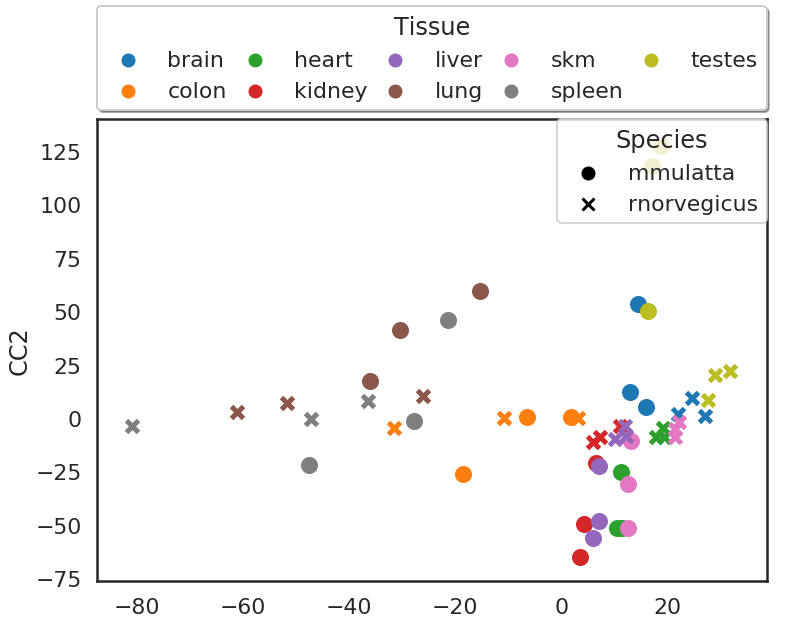

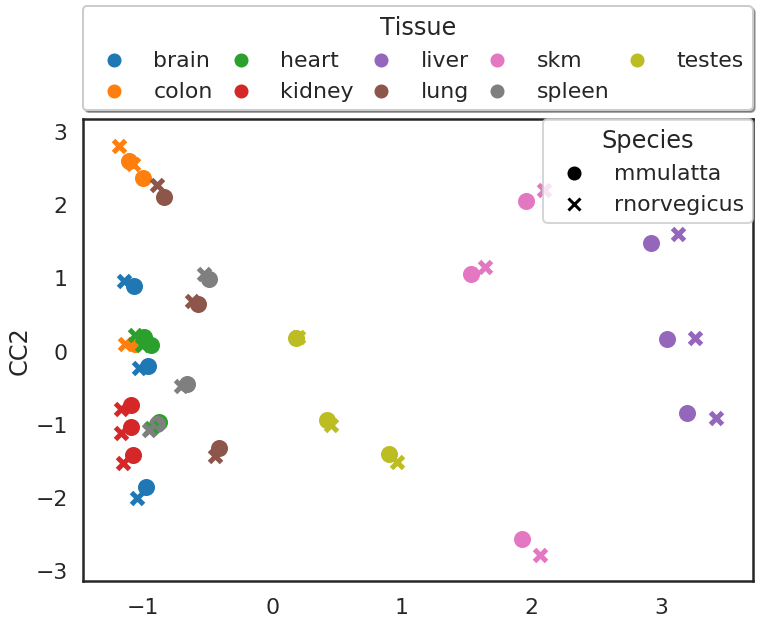

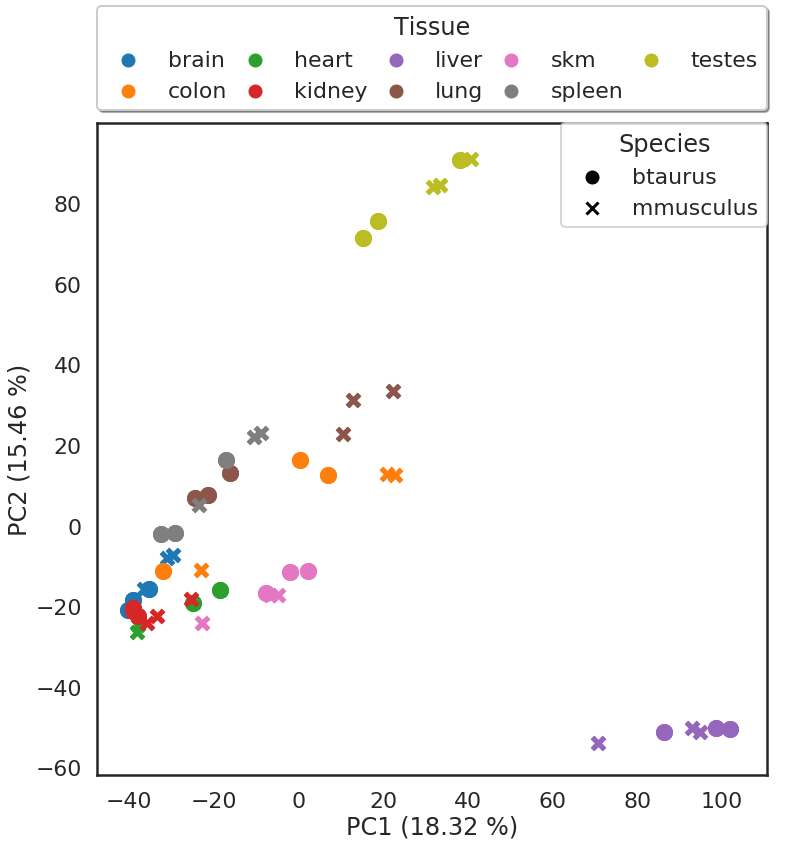

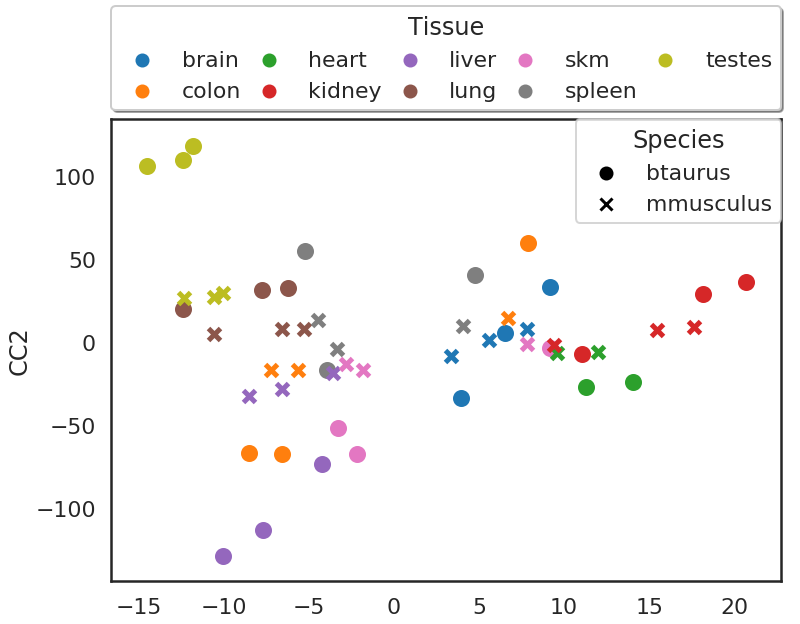

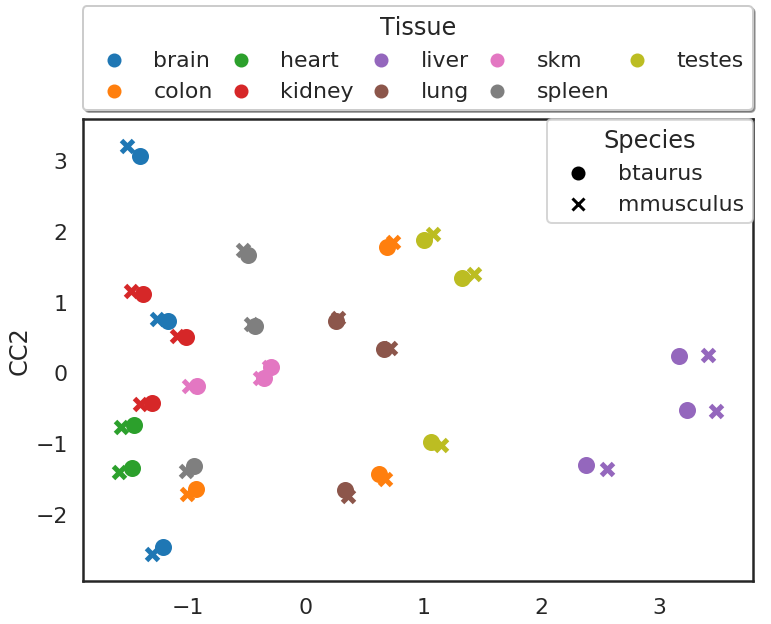

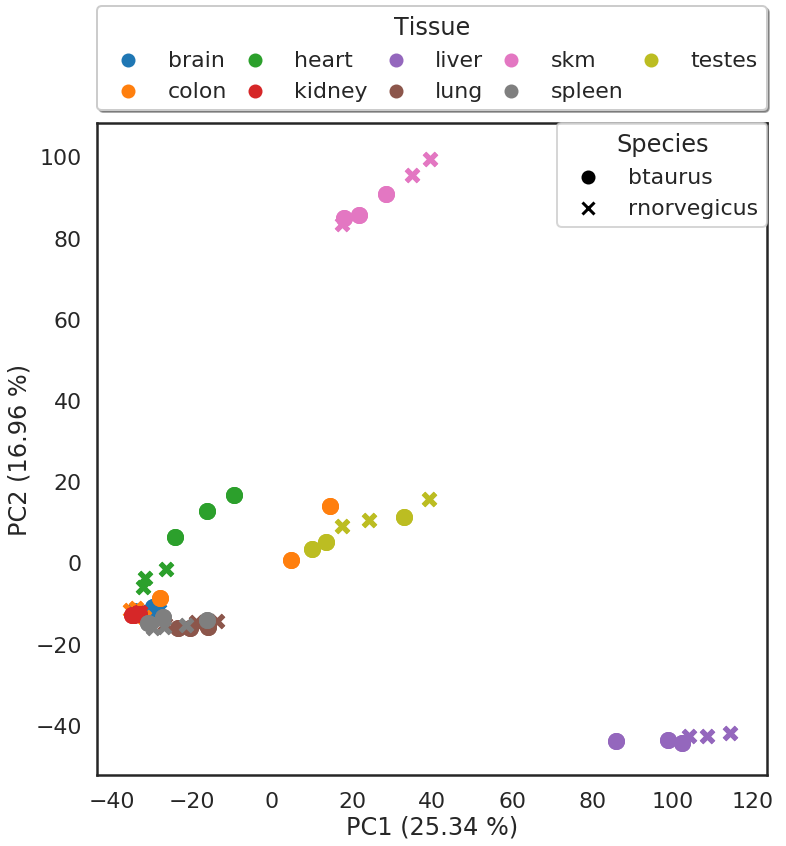

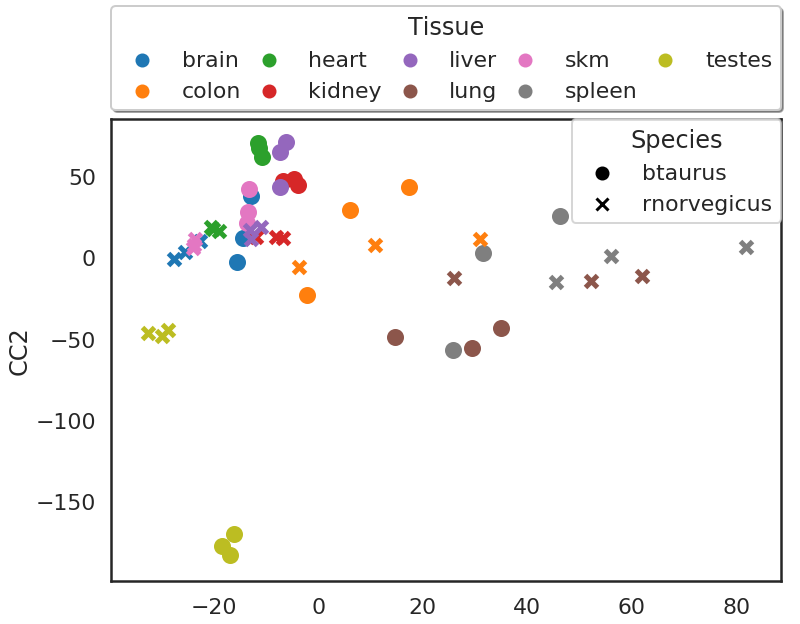

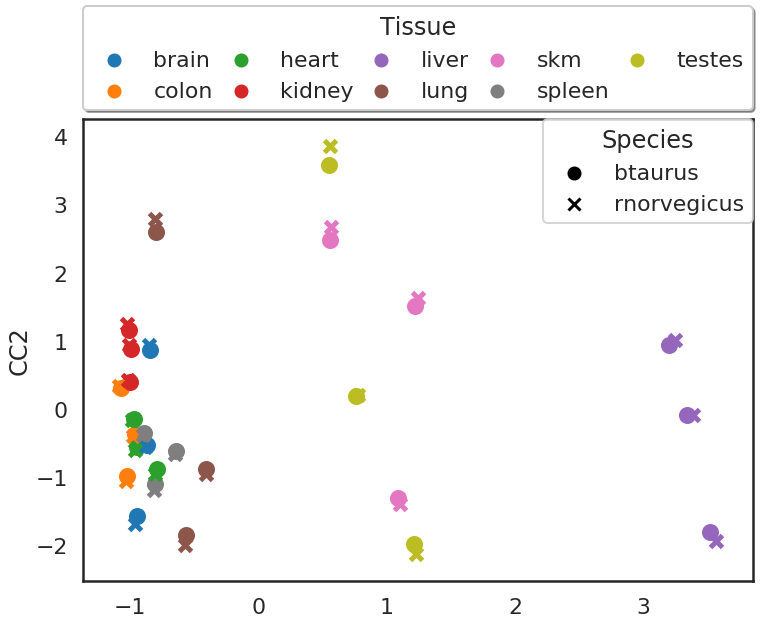

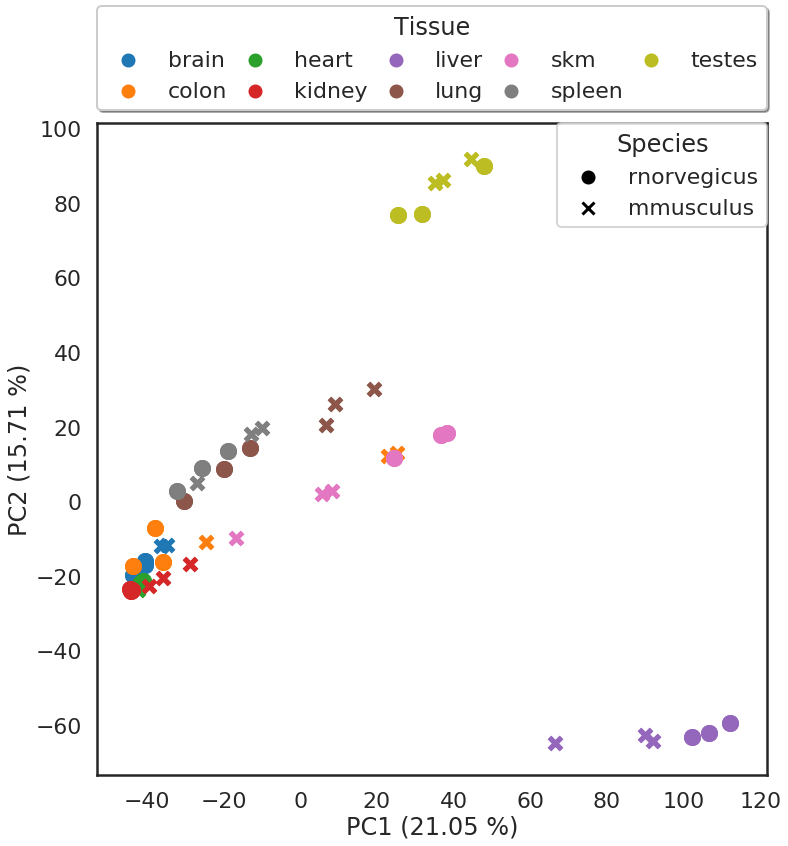

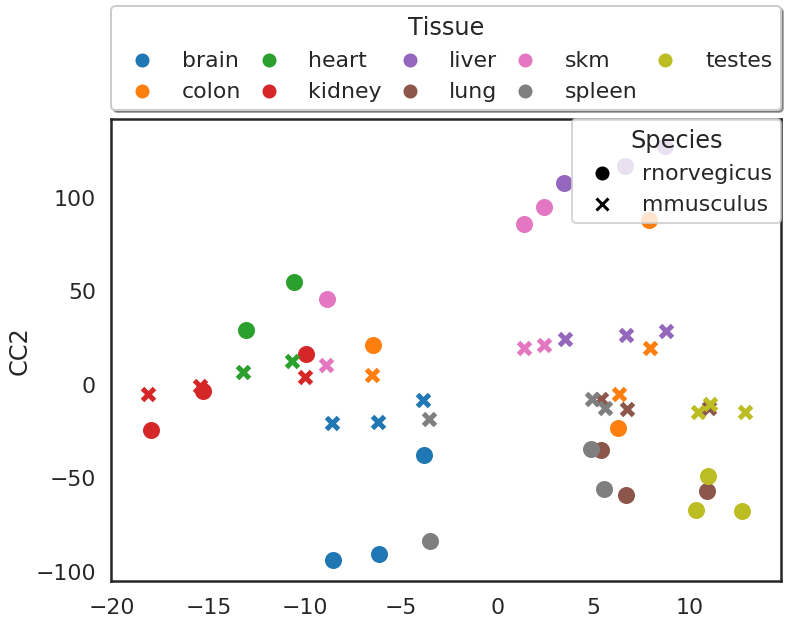

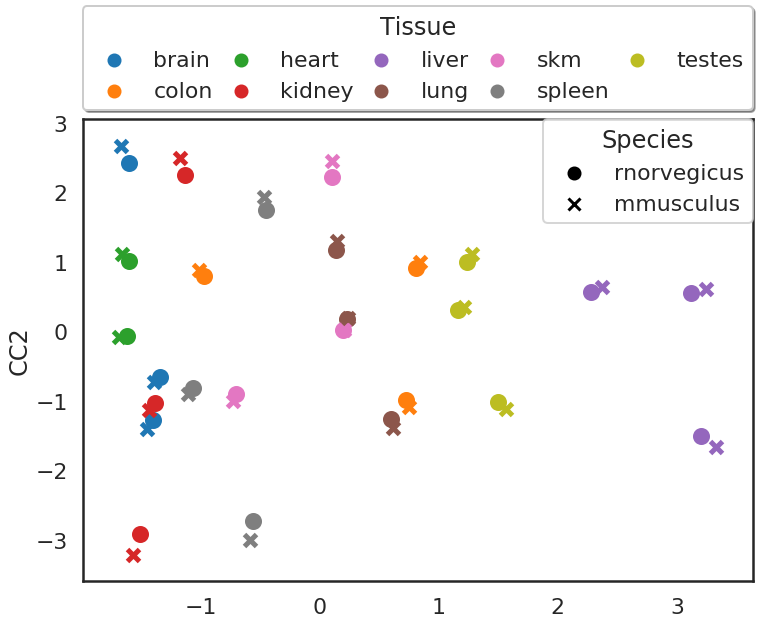

In [275]:
for species_pair, counts in pairwise_kallisto_counts_normalized.items():
    X = counts.values
    target_names = counts.index
    X_r, fig = do_PCA(X, target_names)
    species1, species2 = species_pair.split('_')
    fig.savefig('../SRP016501_plots/pca_normalized_{}_{}.pdf'.format(species, species2), 
                bbox_inches='tight')    
    X = pairwise_kallisto_counts_normalized_individual[species_pair][species1]
    Y = pairwise_kallisto_counts_normalized_individual[species_pair][species2] 
    fig = do_CCA(X, Y, target_names)
    fig.savefig('../SRP016501_plots/cca_normalized_{}_{}.pdf'.format(species, species2),
                bbox_inches='tight')    
    X = X_r[:X.shape[0],]
    Y = X_r[X.shape[0]:,]
    fig = do_CCA(X, Y, target_names)
    fig.savefig('../SRP016501_plots/cca_on_pca_{}_{}.pdf'.format(species, species2),
                bbox_inches='tight')    


In [278]:

species = ["bos_taurus"
           "rattus_norvegicus",
           "pongo_abelii",
           "monodelphis_domestica",
           "macaca_mulatta",
           "pan_troglodytes",
           "mus_musculus",
           "homo_sapiens",
           "gallus_gallus",
           "ornithorhynchus_anatinus",
           "gorilla_gorilla",
           "pan_paniscus"]
species_short_form = []
for sp in species:                      
    short_form = sp[0]+sp.split('_')[-1]
    species_short_form.append(short_form)
    

In [279]:
species_short_form

['bnorvegicus',
 'pabelii',
 'mdomestica',
 'mmulatta',
 'ptroglodytes',
 'mmusculus',
 'hsapiens',
 'ggallus',
 'oanatinus',
 'ggorilla',
 'ppaniscus']

In [294]:
species_wise_tissues = defaultdict(list)

for f in glob.glob('../cross-species-data/SRP016501-*_kallisto_gene_tables.tsv'):
    sample_name = f.split('/')[-1].replace('_kallisto_gene_tables.tsv', '')
    srp, species = sample_name.split('-')
    
    #species = species[0] + species.split('_')[-1]
    df = pd.read_table(f)
    tissues = sorted(set([x.split('_')[1] for x in df.columns]))
    for index, tissue in enumerate(tissues):
        if tissue in TISSUES_SHORT_FORM_MAP.keys():
            tissues[index] = TISSUES_SHORT_FORM_MAP[tissue]
            
    species_wise_tissues[species]+=list(tissues)

In [297]:
species_wise_tissues

defaultdict(list,
            {'gallus_gallus': ['brain',
              'colon',
              'heart',
              'kidney',
              'liver',
              'lung',
              'muscle',
              'spleen',
              'testes'],
             'macaca_mulatta': ['brain',
              'colon',
              'heart',
              'kidney',
              'liver',
              'lung',
              'muscle',
              'spleen',
              'testes'],
             'bos_taurus': ['brain',
              'colon',
              'heart',
              'kidney',
              'liver',
              'lung',
              'muscle',
              'spleen',
              'testes'],
             'mus_musculus': ['brain',
              'colon',
              'heart',
              'kidney',
              'liver',
              'lung',
              'muscle',
              'spleen',
              'testes'],
             'rattus_norvegicus': ['brain',
              'colon',
      

In [300]:
species_wise_tissues = defaultdict(list)

for f in glob.glob('../cross-species-data/SRP007412-*_kallisto_gene_tables.tsv'):
    sample_name = f.split('/')[-1].replace('_kallisto_gene_tables.tsv', '')
    srp, species = sample_name.split('-')
    
    #species = species[0] + species.split('_')[-1]
    df = pd.read_table(f)
    tissues = sorted(set([x.split('_')[0] for x in df.columns]))
    for index, tissue in enumerate(tissues):
        if tissue in TISSUES_SHORT_FORM_MAP.keys():
            tissues[index] = TISSUES_SHORT_FORM_MAP[tissue]
            
    species_wise_tissues[species]+=list(tissues)

In [301]:
species_wise_tissues

defaultdict(list,
            {'gallus_gallus': ['brain',
              'cerebellum',
              'heart',
              'kidney',
              'liver',
              'testes'],
             'ornithorhynchus_anatinus': ['brain',
              'cerebellum',
              'heart',
              'kidney',
              'liver',
              'testes'],
             'macaca_mulatta': ['brain',
              'cerebellum',
              'heart',
              'kidney',
              'liver',
              'testes'],
             'gorilla_gorilla': ['brain',
              'cerebellum',
              'heart',
              'kidney',
              'liver',
              'testes'],
             'pan_paniscus': ['brain',
              'cerebellum',
              'heart',
              'kidney',
              'liver',
              'testes'],
             'pan_troglodytes': ['brain',
              'cerebellum',
              'heart',
              'kidney',
              'liver',
              

In [304]:
for x in SPECIES_COMMON_NAME_MAP_SHORT.values():
    print(x)

Cow
Rat
Orangutan
Opposum
Macaque
Chimpanzee
Mouse
Human
Chicken
Platypus
Gorrila
Bonobos
